In [1]:
# refinando Caso Drag

In [114]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import scipy as sc
import sympy as sp
#%matplotlib widget
import serial,socket,os,glob,sys
#import atexit
import numpy as np
import pandas as pd
import time, threading,sys,glob
from ipywidgets import interact, interact_manual,interactive,widgets,Layout
colores = (plt.rcParams['axes.prop_cycle'].by_key()['color'])
import tifffile as tif
import skimage as sk
from IPython.display import Latex
from funciones_wake import *
from scipy.signal import find_peaks
mks = ['s','o','>','p','v','^','*']




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


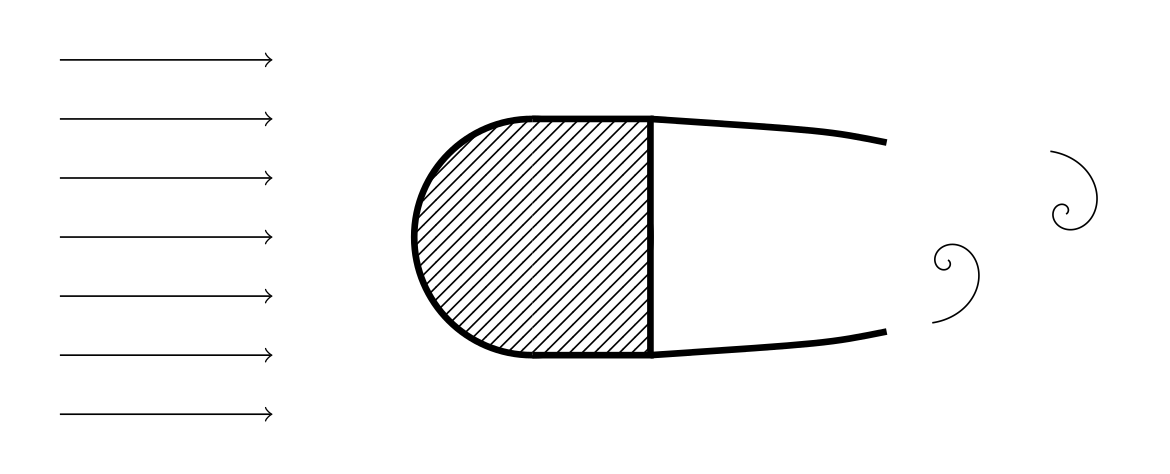

In [115]:
rho = 1.2
Lspan= 35e-2
D = 5e-2
Sf = Lspan*D
nu = 15e-6
scale_force = 1/241  # de gramo a newton  
g = 9.8
rho_50 = 1305
rho_75 = 1902
y1_50 = 37e-3
y1_75 = 50e-3
Largos  = np.array([0.75,1,1.25,1.5])
escala0 = 1/475  #px/

In [128]:
lista_soporte = np.sort(glob.glob('medidas/Dshape_soporte_V*'))
caso_soporte = caso_drag(lista_soporte)
lista_referencia = np.sort(glob.glob('medidas/Dshape_e00*'))
caso_referencia = caso_drag(lista_referencia)

casos_e50, casos_e75, casos_e1000,casos_e1000_b=  [[],[],[],[]]
for Li in Largos:
    lista_e50 = np.sort(glob.glob(f'medidas/Dshape_e50_L{int(Li*100):03d}*'))
    lista_e75 = np.sort(glob.glob(f'medidas/Dshape_e75_L{int(Li*100):03d}*'))
    lista_e1000 = np.sort(glob.glob(f'medidas_ene_2025//Dshape_e1000_L{int(Li*100):03d}*'))
    lista_e1000_back = np.sort(glob.glob(f'medidas/back/Dshape_e1000_L{int(Li*100):03d}*'))
    casos_e50.append(caso_drag(lista_e50))
    casos_e75.append(caso_drag(lista_e75))
    casos_e1000.append(caso_drag(lista_e1000))
    casos_e1000_b.append(caso_drag(lista_e1000_back))

    
FD_s = caso_soporte.df['FD_m'][caso_soporte.index_casos]
U_s = caso_soporte.df['velocity'][caso_soporte.index_casos]

p1_soporte = np.polyfit(U_s,FD_s,2)
F_soporte = np.poly1d(p1_soporte)

FD_s_referencia = caso_referencia.df['FD_m'][caso_referencia.index_casos]
U_s_referencia = caso_referencia.df['velocity'][caso_referencia.index_casos]


p1_referencia = np.polyfit(U_s_referencia,FD_s_referencia,2)
F_referencia = np.poly1d(p1_referencia)

In [142]:
caso = casos_e1000[3]
data_files = caso.df   
lista_files = caso.df['file'].to_numpy()
lista_files_temp  =  np.zeros_like(lista_files) 
lista_files_tempn = np.zeros((len(lista_files),1))


index_casos_0 =  data_files['volt'].isin([0.0])
index_file_ref = np.zeros((len(lista_files),1)) 
file_ref = np.zeros_like(lista_files)
data_files['index_file_ref'] = index_file_ref
data_files['file_ref'] = file_ref
data_files['FD_m'] = index_file_ref*0.0
lista_files_0 = data_files[index_casos_0]['time_ind'].to_numpy()

for i,filei in enumerate(lista_files):
    lista_files_temp[i],lista_files_tempn[i] = get_modified_date(filei)
 
for i, casoi in enumerate(data_files.itertuples()):
    filei = casoi.file
    index_file_ref_i = np.argmin(np.abs(casoi.time_ind-lista_files_0))
    #data_files.at[i,'index_file_ref'] = index_file_ref_i
    ti = float(filei.split('e_e')[1].split('_')[0])
    Li = float(filei.split('_L')[1].split('_')[0])/100
    filei_ref = 'medidas/zeros/'+filei.split('/')[1].split('_delta')[0]+'_deltaV0.csv'
    FD_raw_ref = pd.read_csv(filei_ref,header=None).to_numpy().mean()
    #data_files.at[i,'file_ref'] = filei_ref
    FD_raw = read_cd_csv(filei)

    data_files.at[i,'FD_m'] = (FD_raw -FD_raw_ref)*scale_force

In [143]:
np.argmin(np.abs(casoi.time_ind-lista_files_0))

0

In [144]:
casoi.time_ind

1738265775.2909856

In [145]:
lista_files_0

array([1.73826564e+09])

In [146]:
lista0 = data_files['file'][index_casos_0].to_numpy()
for listai in lista0:
    print(read_cd_csv(listai))

-437.5140480961924


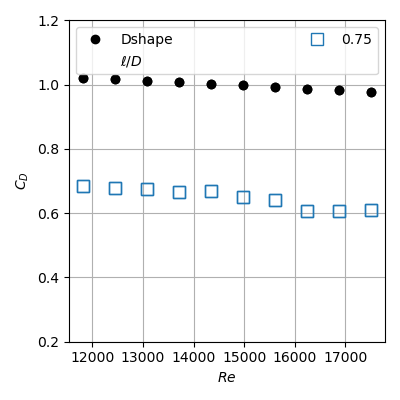

In [16]:
plt.close('all')
fig1,ax1 = plt.subplots(figsize=(4,4))
cd_ref = (F_referencia(U_s_referencia)-F_soporte(U_s_referencia))/(1/2*rho*U_s_referencia**2*Sf)

ax1.plot(U_s_referencia*D/nu,cd_ref,label = 'Dshape' 
         ,linestyle='none',
         fillstyle='full',color='k',marker = 'o',markersize=6)
ax1.plot([],[],linestyle='none',color='w', label='$\ell/D$')
for i, casoi in enumerate(casos_e1000[:1]):
    FD_s = casoi.df['FD_m'][casoi.index_casos].to_numpy()
    U_s = casoi.df['velocity'][casoi.index_casos].to_numpy()
    x,y,z = [[],[],[]]
    for Ui in U_s:
        x.append(Ui)
        y.append(FD_s[U_s == Ui].mean()-F_soporte(Ui))
        z.append(FD_s[U_s == Ui].std())
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    lin1, = ax1.plot(x*D/nu,y/(1/2*rho*Sf*U_s**2),marker=mks[i],fillstyle='none',
                    linestyle='none',markersize=8,label = f'{Largos[i]:.2f}')
    #ax1.plot(U_s*D/nu,F_soporte(U_s)/(1/2*rho*Sf*U_s**2),color=lin1.get_color(),linestyle='--')
ax1.set_xlabel('$Re$')
ax1.set_ylabel('$C_D$');
ax1.legend(ncols=2,mode='expand')
ax1.grid()
ax1.set_ylim([0.2,1.2])
fig1.tight_layout()
#ax1.legend(bbox_to_anchor=(1.15, 1), loc="upper left",fontsize=8,mode='expand')
#h, l = ax1.get_legend_handles_labels()
#ax1.legend(h, l, borderaxespad=0)


In [28]:
read_cd_csv( casos_e1000[0].df['file'][0])

-423.20392785571147

In [29]:
casos_e1000[0].df

,file,time creation,time_ind,volt,velocity,index_file_ref,file_ref,FD_m
0,medidas_ene_2025/Dshape_e1000_L075_deltaV0_0,Thu Jan 30 14:33:35 2025,1.738258e+09,0.0,0.0000,0.0,medidas_ene_2025/Dshape_e1000_L075_deltaV0_0,0.000000
1,medidas_ene_2025/Dshape_e1000_L075_deltaV0_1,Thu Jan 30 14:28:33 2025,1.738258e+09,0.0,0.0000,1.0,medidas_ene_2025/Dshape_e1000_L075_deltaV0_1,0.000000
2,medidas_ene_2025/Dshape_e1000_L075_deltaV0_2,Thu Jan 30 14:46:27 2025,1.738259e+09,0.0,0.0000,2.0,medidas_ene_2025/Dshape_e1000_L075_deltaV0_2,0.000000
3,medidas_ene_2025/Dshape_e1000_L075_deltaV0_3,Thu Jan 30 14:46:42 2025,1.738259e+09,0.0,0.0000,3.0,medidas_ene_2025/Dshape_e1000_L075_deltaV0_3,0.000000
4,medidas_ene_2025/Dshape_e1000_L075_deltaV40_0,Thu Jan 30 14:45:25 2025,1.738259e+09,40.0,3.5450,2.0,medidas_ene_2025/Dshape_e1000_L075_deltaV0_2,0.143412
5,medidas_ene_2025/Dshape_e1000_L075_deltaV40_1,Thu Jan 30 14:45:37 2025,1.738259e+09,40.0,3.5450,2.0,medidas_ene_2025/Dshape_e1000_L075_deltaV0_2,0.143336
6,medidas_ene_2025/Dshape_e1000_L075_deltaV42_0,Thu Jan 30 14:44:46 2025,1.738259e+09,42.0,3.7344,2.0,medidas_ene_2025/Dshape_e1000_L075_deltaV0_2,0.157938
7,medidas_ene_2025/Dshape_e1000_L075_deltaV42_1,Thu Jan 30 14:44:58 2025,1.738259e+09,42.0,3.7344,2.0,medidas_ene_2025/Dshape_e1000_L075_deltaV0_2,0.158189
8,medidas_ene_2025/Dshape_e1000_L075_deltaV44_0,Thu Jan 30 14:44:05 2025,1.738259e+09,44.0,3.9238,2.0,medidas_ene_2025/Dshape_e1000_L075_deltaV0_2,0.174290
9,medidas_ene_2025/Dshape_e1000_L075_deltaV44_1,Thu Jan 30 14:44:14 2025,1.738259e+09,44.0,3.9238,2.0,medidas_ene_2025/Dshape_e1000_L075_deltaV0_2,0.174056
